In [5]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



import warnings
warnings.filterwarnings('ignore')

In [6]:
# First, let's reload the original datasets since the previous dataframes have been altered through oversampling
orig_data = pd.read_csv('/content/original_log.csv')

# Rename the columns for clarity
orig_data.rename(columns={'0': 'Log_Return'}, inplace=True)
orig_data.drop(orig_data.tail(1).index, inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: '/content/original_log.csv'

In [ ]:
orig_data


,Log_Return
0,-0.039099
1,0.001920
2,0.000955
3,0.026730
4,0.011128
...,...
2255,-0.018472
2256,-0.009765
2257,0.005764
2258,0.005342


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to prepare data for LSTM model
def prepare_lstm_data(df, n_steps):
    X, y = [], []
    for i in range(len(df) - n_steps):
        X.append(df[i:i + n_steps])
        y.append(df[i + n_steps])
    return np.array(X), np.array(y)

# Number of past days to use for predicting the next value
n_steps = 10

# Selecting the 'Log_Return' column from prova_df for LSTM input
prova_log_returns = orig_data['Log_Return'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prova_scaled = scaler.fit_transform(prova_log_returns)

# Prepare data for LSTM
X_prova, y_prova = prepare_lstm_data(prova_scaled, n_steps)

# Split the data into training and testing sets
X_train_prova, X_test_prova, y_train_prova, y_test_prova = train_test_split(X_prova, y_prova, test_size=0.01, random_state=42)

X_train_prova.shape, X_test_prova.shape, y_train_prova.shape, y_test_prova.shape


((2227, 10, 1), (23, 10, 1), (2227, 1), (23, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
X_train_prova.shape

(2227, 10, 1)

In [ ]:
input_shape = (10,1)
#input_shape= (X_train_prova[1],X_train_prova[2])
model = create_lstm_model(input_shape)
history = model.fit(X_train_prova, y_train_prova, epochs=100, batch_size=32, validation_data=(X_test_prova, y_test_prova))


Epoch 1/100
70/70 [==============================] - 9s 45ms/step - loss: 0.0177 - val_loss: 8.7100e-04
Epoch 2/100
70/70 [==============================] - 1s 18ms/step - loss: 0.0060 - val_loss: 9.5971e-04
Epoch 3/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0058 - val_loss: 8.7281e-04
Epoch 4/100
70/70 [==============================] - 1s 20ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 5/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0055 - val_loss: 9.1256e-04
Epoch 6/100
70/70 [==============================] - 1s 14ms/step - loss: 0.0055 - val_loss: 9.4897e-04
Epoch 7/100
70/70 [==============================] - 1s 10ms/step - loss: 0.0057 - val_loss: 0.0012
Epoch 8/100
70/70 [==============================] - 1s 10ms/step - loss: 0.0053 - val_loss: 9.0581e-04
Epoch 9/100
70/70 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 8.5477e-04
Epoch 10/100
70/70 [==============================] - 1s 10ms/step - loss

In [ ]:
predicted_prova = model.predict(X_test_prova)

1/1 [==============================] - 1s 580ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

# Inverse transform the predictions and actual values to their original scale
predicted_prova_inversed = scaler.inverse_transform(predicted_prova)
y_test_prova_inversed = scaler.inverse_transform(y_test_prova)

# Calculate MSE
mse_prova = mean_squared_error(y_test_prova_inversed, predicted_prova_inversed)
print("Mean Squared Error for Prova dataset:", mse_prova)


Mean Squared Error for Prova dataset: 4.1417251468161344e-05


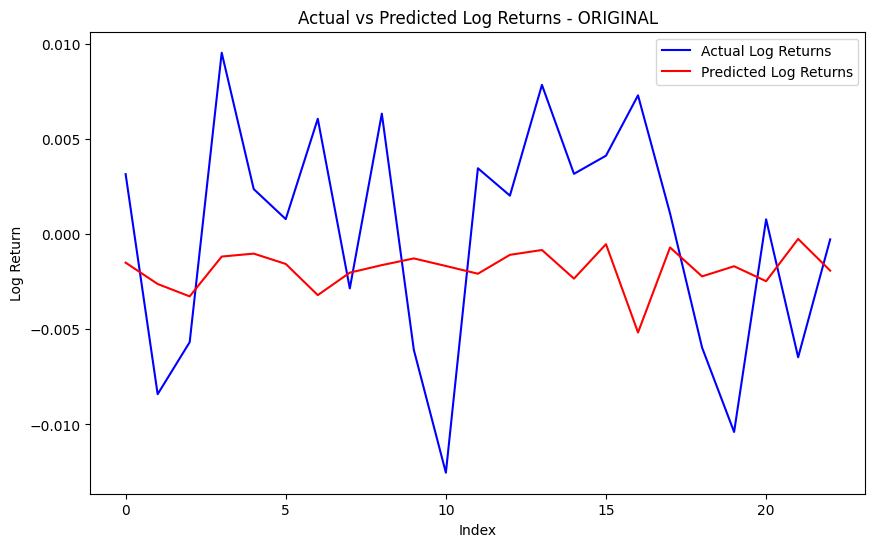

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_prova_inversed, label='Actual Log Returns', color='blue')
plt.plot(predicted_prova_inversed, label='Predicted Log Returns', color='red')
plt.title('Actual vs Predicted Log Returns - ORIGINAL')
plt.xlabel('Index')
plt.ylabel('Log Return')
plt.legend()
plt.show()


In [ ]:
from math import sqrt
rmse = sqrt (mse_prova)
rmse

0.006435623626981409

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_prova_inversed, predicted_prova_inversed)

0.005582366204498748

In [ ]:
# Generate predictions for the training set
predicted_train_prova = model.predict(X_train_prova)


70/70 [==============================] - 0s 4ms/step


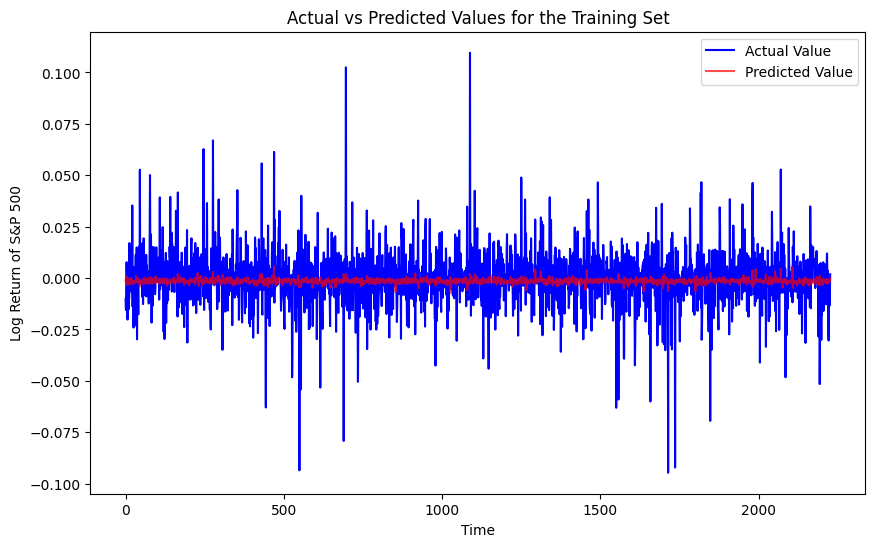

In [ ]:
import matplotlib.pyplot as plt

# Inverse transform the predictions and actual values to their original scale
predicted_train_prova_inv = scaler.inverse_transform(predicted_train_prova)
y_train_prova_inv = scaler.inverse_transform(y_train_prova.reshape(-1, 1))


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate mean and standard deviation of the actual values
mu = np.mean(y_train_prova_inv)
sigma = np.std(y_train_prova_inv)

# Identify indices of extreme values
extreme_indices = np.where((y_train_prova_inv < (mu - 2 * sigma)) | (y_train_prova_inv > (mu + 2 * sigma)))[0]

# Filter actual and predicted values for extreme values
actual_extreme_values = y_train_prova_inv[extreme_indices]
predicted_extreme_values = predicted_train_prova_inv[extreme_indices]

# Calculate RMSE for extreme values
rmse_extreme = np.sqrt(mean_squared_error(actual_extreme_values, predicted_extreme_values))

print(f'RMSE for Extreme Values: {rmse_extreme}')


RMSE for Extreme Values: 0.04442668813854585


In [ ]:
mean_absolute_error(actual_extreme_values, predicted_extreme_values)

0.04133415044869559

In [ ]:
# Calculate mean and standard deviation of the actual values
mu = np.mean(y_test_prova_inversed)
sigma = np.std(y_test_prova_inversed)
# Identify indices of extreme values
extreme_indices = np.where((y_test_prova_inversed < (mu - 2 * sigma)) | (y_test_prova_inversed > (mu + 2 * sigma)))[0]

# Filter actual and predicted values for extreme values
actual_extreme_values = y_test_prova_inversed[extreme_indices]
predicted_extreme_values = predicted_prova_inversed[extreme_indices]

# Calculate RMSE for extreme values
rmse_extreme = np.sqrt(mean_squared_error(actual_extreme_values, predicted_extreme_values))

print(f'RMSE for Extreme Values: {rmse_extreme}')

RMSE for Extreme Values: 0.010868693856043067


In [ ]:
  mean_absolute_error(actual_extreme_values, predicted_extreme_values)

0.010868693856043067